In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [62]:
font = {'family': 'Verdana',
        'weight': 'normal',
        'size': 28}
rc('font', **font)

In [6]:
df = pd.read_csv('df/labeled/df.csv')

In [12]:
X = df.drop(['ref1', 'ref2', 'label'], axis=1)
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

In [27]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## Tuning parameters

In [164]:
skf = StratifiedKFold(n_splits=5, shuffle=True) 

parameters = {'n_estimators': [5, 10, 15, 20, 30, 50, 75, 100],
    'max_features': [2, 3, 4, 5], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]}
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight={1: 0.994, 0: 0.006})
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 92.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={1: 0.994, 0: 0.006},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 50, 75, 100], 'max_features': [2, 3, 4, 5], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [165]:
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={1: 0.994, 0: 0.006},
            criterion='gini', max_depth=20, max_features=3,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Fit

In [172]:
rfc = RandomForestClassifier(bootstrap=True, class_weight={1: 0.994, 0: 0.006},
            criterion='gini', max_depth=20, max_features=3,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
rfc.fit(X_train, y_train, sample_weight=np.array([120 if i == 0 else 1 for i in y_train]))

Random forest accuracy: 0.996947779


## Feature importance

/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


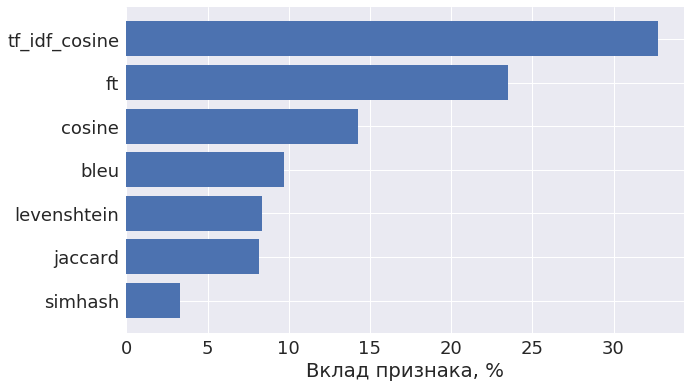

In [175]:
features = X_train.columns.tolist()
rfc_fi = pd.DataFrame(features)
rfc_fi.columns = ['feature']
rfc_fi['importance'] = 100.0 * rfc.feature_importances_
sns.set(font_scale=1.8)
# Choosing top important features
# rfc_top_features = list(rfc_fi.sort_values('importance', ascending=False)['feature'].head(20))

# Plot feature importance

n = len(features)
pos = np.arange(n)[::-1] + 1

plt.figure(figsize=(10, 6))
#plt.axis([0, 100, 0, n + 1]) 
plt.barh(pos, rfc_fi.sort_values('importance', ascending=False)['importance'].head(n), align='center')
plt.yticks(pos, rfc_fi.sort_values('importance', ascending=False)['feature'].head(n))
plt.xlabel('Вклад признака, %');
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')

In [173]:
with open('rf.pkl', 'wb') as p:
    pickle.dump(rfc, p)    

In [168]:
predicted = rfc.predict(X_test)

## Precision, recall, F1-score

In [169]:
print ("Precision:", precision_score(y_test, predicted))

0.80132450331125826

In [170]:
print ("Recall:", recall_score(y_test, predicted))

0.70553935860058314

In [171]:
print ("F1-score:", f1_score(y_test, predicted))

0.75038759689922474